In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/Colab Notebooks/13 - NLP/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/13 - NLP


In [ ]:
import os 
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import spacy, nltk, re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from pickle import dump, load
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import Dropout, Dense, Input, Activation, LSTM, Embedding, TimeDistributed, MaxPooling1D
from tensorflow.keras.models import Model, Sequential, load_model

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

# Data loading

In this part, we will import the preprocessed data and explore it.

In [ ]:
data = pd.read_csv("data/ner_dataset.csv", encoding = "ISO-8859-1") 
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
with open('data/large/words.txt') as f:
    vocab = [sent for sent in f.read().splitlines()]
    
with open('data/large/tags.txt') as f:
    tag = [sent for sent in f.read().splitlines()]

with open('data/large/train/sentences.txt') as f:
    train_x = [sent for sent in f.read().splitlines()]

with open('data/large/train/labels.txt') as f:
    train_y = [sent for sent in f.read().splitlines()]
    
with open('data/large/val/sentences.txt') as f:
    val_x = [sent for sent in f.read().splitlines()]

with open('data/large/val/labels.txt') as f:
    val_y = [sent for sent in f.read().splitlines()]
    
with open('data/large/test/sentences.txt') as f:
    test_x = [sent for sent in f.read().splitlines()]

with open('data/large/test/labels.txt') as f:
    test_y = [sent for sent in f.read().splitlines()]

In [ ]:
# tokenized and one hot with keras text
tokenizer_x = text.Tokenizer(oov_token='UNK')
tokenizer_x.fit_on_texts(vocab)
tokenizer_y = text.Tokenizer(lower=False, filters=[])
tokenizer_y.fit_on_texts(tag)

# label encoder
train_x_token = tokenizer_x.texts_to_sequences(train_x)
train_y_token = tokenizer_y.texts_to_sequences(train_y)
val_x_token = tokenizer_x.texts_to_sequences(val_x)
val_y_token = tokenizer_y.texts_to_sequences(val_y)
test_x_token = tokenizer_x.texts_to_sequences(test_x)
test_y_token = tokenizer_y.texts_to_sequences(test_y)

# padding
train_x_token = sequence.pad_sequences(train_x_token, padding='post', truncating='post', maxlen=30)
val_x_token = sequence.pad_sequences(val_x_token, padding='post', truncating='post', maxlen=30)
test_x_token = sequence.pad_sequences(test_x_token, padding='post', truncating='post', maxlen=30)

train_y_token = sequence.pad_sequences(train_y_token, padding='post', truncating='post', maxlen=30)
val_y_token = sequence.pad_sequences(val_y_token, padding='post', truncating='post', maxlen=30)
test_y_token = sequence.pad_sequences(test_y_token, padding='post', truncating='post', maxlen=30)

# one hot of y --> sparse
train_y_token = tf.one_hot(train_y_token, len(tokenizer_y.index_word))
val_y_token = tf.one_hot(val_y_token, len(tokenizer_y.index_word))
test_y_token = tf.one_hot(test_y_token, len(tokenizer_y.index_word))

In [ ]:
print(train_x_token.shape)
print(train_y_token.shape)

(33570, 30)
(33570, 30, 17)


The tag_map corresponds to one of the possible tags a word can have. Run the cell below to see the possible classes you will be predicting. The prepositions in the tags mean:
* I: Token is inside an entity.
* B: Token begins an entity.

So the coding scheme that tags the entities is a minimal one where B- indicates the first token in a multi-token entity, and I- indicates one in the middle of a multi-token entity. If you had the sentence 

**"Sharon flew to Miami on Friday"**

the outputs would look like:

```
Sharon B-per
flew   O
to     O
Miami  B-geo
on     O
Friday B-tim
```

your tags would reflect three tokens beginning with B-, since there are no multi-token entities in the sequence. But if you added Sharon's last name to the sentence: 

**"Sharon Floyd flew to Miami on Friday"**

```
Sharon B-per
Floyd  I-per
flew   O
to     O
Miami  B-geo
on     O
Friday B-tim
```

then your tags would change to show first "Sharon" as B-per, and "Floyd" as I-per, where I- indicates an inner token in a multi-token sequence.

# Model Building

In [ ]:
def lstm_model(n_x, n_y, n_h, vocab_size, emb_dim):
    i = Input(shape=(n_x, )) # (m, n_x)
    x = Embedding(vocab_size + 1, emb_dim)(i) # (m, vocab_len, emb_dim)
    x = LSTM(n_h, return_sequences=True)(x) # (m, vocab_len, n_h) 
    x = Dropout(0.5)(x) # (m, vocab_len, n_h) 
    x = LSTM(n_h, return_sequences=True)(x) # (m, vocab_len, n_h) 
    x = TimeDistributed(Dense(n_y, activation='softmax'))(x) # (m, vocab_len, n_y)
    model = Model(i, x)
    return model
  
tf.keras.backend.clear_session()

In [ ]:
with strategy.scope():
  model = lstm_model(train_x_token.shape[1], tokenizer_y.document_count, 128, tokenizer_x.document_count, 50)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 50)            1759050   
_________________________________________________________________
lstm (LSTM)                  (None, 30, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 17)            2193      
Total params: 1,984,475
Trainable params: 1,984,475
Non-trainable params: 0
___________________________________________________

In [ ]:
r = model.fit(train_x_token, train_y_token, batch_size=64, epochs=5, validation_data=(val_x_token, val_y_token))

Epoch 1/5
525/525 [==============================] - 13s 24ms/step - loss: 0.2110 - accuracy: 0.9332 - val_loss: 0.2872 - val_accuracy: 0.9133
Epoch 2/5
525/525 [==============================] - 12s 24ms/step - loss: 0.2006 - accuracy: 0.9364 - val_loss: 0.2904 - val_accuracy: 0.9147
Epoch 3/5
525/525 [==============================] - 12s 24ms/step - loss: 0.1900 - accuracy: 0.9397 - val_loss: 0.2897 - val_accuracy: 0.9137
Epoch 4/5
525/525 [==============================] - 12s 23ms/step - loss: 0.1810 - accuracy: 0.9426 - val_loss: 0.3021 - val_accuracy: 0.9145
Epoch 5/5
525/525 [==============================] - 12s 24ms/step - loss: 0.1735 - accuracy: 0.9448 - val_loss: 0.3066 - val_accuracy: 0.9144


<function matplotlib.pyplot.show>

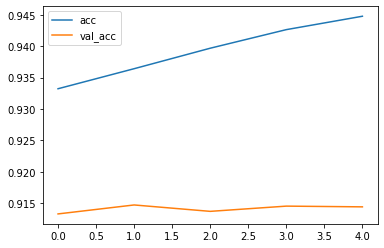

In [ ]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show

<a name="4"></a>
# Part 3:  Evaluation

In [ ]:
loss, acc = model.evaluate(test_x_token, test_y_token, batch_size=128)
print(acc)

57/57 [==============================] - 2s 19ms/step - loss: 0.3009 - accuracy: 0.9154
0.9153785109519958


In [ ]:
def predict(sentence, model):
    tokenized_sent = tokenizer_x.texts_to_sequences(sentence)
    tokenized_sent = sequence.pad_sequences(tokenized_sent, padding='post', truncating='post', maxlen=30)
    pred = model.predict(tokenized_sent)
    pred = np.argmax(pred, axis=-1)
    pred_lis = []
    for out in pred:
        pred = [tokenizer_y.index_word.get(x) for x in out]
        pred_lis.append(pred)
    return pred_lis

In [ ]:
# New york times news:
sentence = ["Peter Navarro, the White House director of trade and manufacturing policy of U.S, \
said in an interview on Sunday morning that the White House was working to prepare for \
the possibility of a second wave of the coronavirus in the fall, though he said it wouldn’t necessarily come"]

predictions = predict(sentence, model)

In [ ]:
for x, y in zip(sentence[0].split(' '), predictions[0]):
    if y != 'O':
        print(x, y)

Peter B-per
Navarro, I-per
White B-org
House I-org
director I-org
said B-geo
morning B-tim
that I-tim
House B-org
was I-org
